# Load Dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import shutil
import zipfile
import os

file_name = 'Dataset_TXA.zip'

# copying the dataset to the temporary workspace
print('Copying Dataset to temporary workspace...')
shutil.copyfile('drive/MyDrive/Dataset_TXA.zip', 'Dataset_TXA.zip')
print('Copied...')

# unzipping the dataset
path = 'Dataset'
with zipfile.ZipFile(file_name, 'r') as zip_ref:
    zip_ref.extractall(path)

#moving inside the Dataset folder
os.chdir(path)
os.getcwd()

Mounted at /content/drive
Copying Dataset to temporary workspace...
Copied...


'/content/Dataset'

# General Preprocessing

In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv('gr_training_set.csv', usecols = ['book_id', 'review_text', 'genre'])

df['n_review_per_book'] = df.groupby('book_id')['book_id'].transform(len)
average_rev = int(df[['book_id', 'n_review_per_book']].drop_duplicates(keep = 'first')['n_review_per_book'].mean())

keep_idx_bool = df['n_review_per_book'] <= average_rev
indexes_to_keep = df[keep_idx_bool].index
index_sampled = df[~keep_idx_bool].groupby('book_id').sample(average_rev, random_state = 42).index
new_indexes = sorted(indexes_to_keep.tolist()+index_sampled.tolist())

df = df.loc[new_indexes].reset_index(drop=True)

#Dropping NaN values
df.dropna(subset=['genre'], inplace=True)

# made it slightly more readable
genres_corresp = ((("Fantasy", "Superheroes", "Shapeshifters", "Science Fiction Fantasy"), #-->
                   ("Fantasy")),
                  (("Romance", "Erotica", "Polyamorous", "Category Romance"), #-->
                   ("Romance")),
                  (("Fiction", "Young Adult", "New Adult", "Womens Fiction", "Adult Fiction", 
                    "Christian Fiction", "Realistic Fiction", "Fan Fiction", "Magical Realism"), #-->
                   ("Fiction")),
                  (("Sequential Art", "Music", "Couture"), #-->
                   ("Art")),
                  (("Thriller", "Mystery", "Crime"), #-->
                   ("Thriller")),
                  (("Science Fiction", ), #just add a single comma to not loop in the string -->
                   ("Science Fiction")),
                  (("Horror", "Paranormal", "Dark", "Suspense"), #-->
                   ("Horror")),
                  (("Classics", "Contemporary", "Poetry", "Plays"), #-->
                   ("Literature")),
                  (("Nonfiction", "Autobiography", "Biography"), #-->
                   ("NonFiction")),
                  (("Historical", "History", "War", "Mythology"), #-->
                   ("History")))

genres_to_keep_dict = {k : v for ks, v in genres_corresp for k in ks}
df = df[df.genre.isin(genres_to_keep_dict.keys())].reset_index(drop=True)
df.genre = df.genre.map(lambda genere: genres_to_keep_dict[genere])

n = 2000
genres_w_more_than_n_reviews = df.groupby('genre')['genre'].transform(len) >= n
df = pd.concat((df[genres_w_more_than_n_reviews].groupby('genre').sample(n=n, random_state = 42), 
                df[~genres_w_more_than_n_reviews]), ignore_index=True)
train_df = df[['review_text', 'genre']]
del df
print(f'Number of Rows: {len(train_df)}')

Number of Rows: 20000


In [ ]:
# loading and preprocessing the test set
test_df = pd.read_csv('gr_test_set.csv', usecols=['review_text', 'genre']).dropna().reset_index(drop=True)
test_df = test_df[test_df.genre.isin(genres_to_keep_dict.keys())].reset_index(drop=True)
test_df.genre = test_df.genre.map(lambda genere: genres_to_keep_dict[genere])

print(f'Number of Rows: {len(test_df)}')

Number of Rows: 373300


# Preprocessing for non pre-trained models

In [2]:
!pip install swifter
!pip install wordcloud
!pip install gensim
!pip install transformers
!pip install spacy
!pip install umap-learn
!spacy download en_core_web_sm

# to remove the output of the installation
from IPython.display import clear_output
clear_output(wait=True)
print('Set up complete')

Set up complete


In [31]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import swifter

default_params = mpl.rcParamsDefault

import re
import time
from collections import Counter

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords

# Pos tagging correspondence
from nltk.corpus import wordnet

# Stop words
from gensim.parsing.preprocessing import remove_stopwords, STOPWORDS
# Compute bigrams.
from gensim.models import Phrases
# Utility to compute dictionary
from gensim.corpora import Dictionary

# Ner visualization
import spacy
from spacy import displacy

import torch

from wordcloud import WordCloud
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Lemmatize the documents.
from nltk.stem.wordnet import WordNetLemmatizer

# Vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

# Topic Distribution with UMAP and tSNE
from yellowbrick.text import UMAPVisualizer
from yellowbrick.text import TSNEVisualizer

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

stop_words = set(STOPWORDS)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [4]:
# cleaning different patterns
def clean_tokens(tokens):
    tokens = re.sub(r'[^\w\s]', '', tokens)
    tokens = re.sub(r'<.*?>', '', tokens) #removing HTMLS
    tokens = re.sub(r"\\", "", tokens) #removing \ character
    tokens = re.sub(r"\n", "", tokens)
    tokens = re.sub(r"http\S+", "", tokens) #removing HTTPS
    tokens = re.sub(r'\b\d+\b', '', tokens) #removing numbers
    
    return tokens.strip().lower()

In [5]:
#cleaning stopwords and words containing non alphanumeric characters
def remove_stop_words(column, pos = False):
    """
    It removes the stop words from a column or an iterable of tokens, 
    the pos parameter specify if the pos is present in the iterable.
    e.g. pos == True iff [(holy, JJ), (crap, NN), (awesome, NN) <-- [0] word, [1] pos

    """

    if pos == False:
        return [[token for token in review_text if (token not in stop_words) and token.isalpha()] for review_text in column]
    else: #token[0] because it is assumed the token is the first position of the tuple
        return [[token for token in review_text if (token[0] not in stop_words) and token[0].isalpha()] for review_text in column]

In [ ]:
# to interpret the postag to wordnet lexicon

def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

In [ ]:
def lemmatize_row(row):
    lemmatizer = WordNetLemmatizer()
    lemmatized_row = list()
    
    for token, pos in row:
        if pos_mapper[pos] is None:
            lemma = lemmatizer.lemmatize(token)
        else:
            lemma = lemmatizer.lemmatize(token, pos = pos_mapper[pos])

        lemmatized_row.append(lemma) # we discarded the pos here

    return lemmatized_row

In [ ]:
#cleaning review_text col
train_df.review_text = train_df.review_text.swifter.apply(lambda x: clean_tokens(x))
train_df["tokenized_text"] = train_df.review_text.swifter.apply(lambda x: word_tokenize(x))
train_df["postagged_text"] = train_df.tokenized_text.swifter.apply(lambda x: nltk.pos_tag(x))

list_of_tags = train_df.postagged_text.swifter.apply(lambda x: [el[1] for el in x if len(el) == 2]).tolist()
set_of_tags = set()

for ls in list_of_tags:
    for tag in ls:
        set_of_tags.add(tag)

pos_mapper = {k : get_wordnet_pos(k) for k in set_of_tags}

train_df["tokenized_text"] = remove_stop_words(train_df["tokenized_text"], pos = False)
train_df["postagged_text"] = remove_stop_words(train_df["postagged_text"], pos = True)
train_df["tokenized_text"] = train_df.tokenized_text.map(lambda x: [el for el in x if len(el) > 2])
train_df["postagged_text"] = train_df.postagged_text.map(lambda x: [el for el in x if len(el[0]) > 2])
train_df['lemmatized_text'] = train_df.postagged_text.swifter.apply(lambda x: lemmatize_row(x))

Pandas Apply:   0%|          | 0/20000 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/20000 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/20000 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/20000 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/20000 [00:00<?, ?it/s]

In [ ]:
train_df

,review_text,genre,tokenized_text,postagged_text,lemmatized_text
0,governor gets his comeuppance and the gang fin...,Art,"[governor, gets, comeuppance, gang, way, woodb...","[(governor, NN), (gets, VBZ), (comeuppance, NN...","[governor, get, comeuppance, gang, way, woodbu..."
1,i originally read these graphic novels back in...,Art,"[originally, read, graphic, novels, got, delux...","[(originally, RB), (read, VB), (graphic, JJ), ...","[originally, read, graphic, novel, get, deluxe..."
2,i like that i hear all the character voices as...,Art,"[like, hear, character, voices, read, honestly...","[(like, IN), (hear, VBP), (character, NN), (vo...","[like, hear, character, voice, read, honestly,..."
3,i an not accurately describe how beautiful the...,Art,"[accurately, beautiful, illustrations, colors,...","[(accurately, RB), (beautiful, JJ), (illustrat...","[accurately, beautiful, illustration, color, b..."
4,all things must come to an end and unfortunate...,Art,"[things, come, end, unfortunately, sandman, bo...","[(things, NNS), (come, VB), (end, NN), (unfort...","[thing, come, end, unfortunately, sandman, boo..."
...,...,...,...,...,...
19995,continuing in the spirit of rereading i am rev...,Thriller,"[continuing, spirit, rereading, revisting, chr...","[(continuing, VBG), (spirit, NN), (rereading, ...","[continue, spirit, reread, revisting, christie..."
19996,edit just finished this one blew me away revi...,Thriller,"[edit, finished, blew, away, review, come, ant...","[(edit, NN), (finished, VBN), (blew, VBD), (aw...","[edit, finish, blow, away, review, come, antic..."
19997,spoiler alert major spoiler ...,Thriller,"[spoiler, alert, major, spoiler, seriously, vi...","[(spoiler, NN), (alert, NN), (major, JJ), (spo...","[spoiler, alert, major, spoiler, seriously, vi..."
19998,okay wow when i saw a review pop up on my fee...,Thriller,"[okay, wow, saw, review, pop, feed, khan, wasn...","[(okay, NN), (wow, NN), (saw, VBD), (review, N...","[okay, wow, saw, review, pop, feed, khan, wasn..."


# BERT

## Preprocessing

In [ ]:
from IPython.display import clear_output

!pip install transformers datasets evaluate
clear_output(wait=True)
_

,review_text,genre,tokenized_text,postagged_text,lemmatized_text
0,governor gets his comeuppance and the gang fin...,Art,"[governor, gets, comeuppance, gang, way, woodb...","[(governor, NN), (gets, VBZ), (comeuppance, NN...","[governor, get, comeuppance, gang, way, woodbu..."
1,i originally read these graphic novels back in...,Art,"[originally, read, graphic, novels, got, delux...","[(originally, RB), (read, VB), (graphic, JJ), ...","[originally, read, graphic, novel, get, deluxe..."
2,i like that i hear all the character voices as...,Art,"[like, hear, character, voices, read, honestly...","[(like, IN), (hear, VBP), (character, NN), (vo...","[like, hear, character, voice, read, honestly,..."
3,i an not accurately describe how beautiful the...,Art,"[accurately, beautiful, illustrations, colors,...","[(accurately, RB), (beautiful, JJ), (illustrat...","[accurately, beautiful, illustration, color, b..."
4,all things must come to an end and unfortunate...,Art,"[things, come, end, unfortunately, sandman, bo...","[(things, NNS), (come, VB), (end, NN), (unfort...","[thing, come, end, unfortunately, sandman, boo..."
...,...,...,...,...,...
19995,continuing in the spirit of rereading i am rev...,Thriller,"[continuing, spirit, rereading, revisting, chr...","[(continuing, VBG), (spirit, NN), (rereading, ...","[continue, spirit, reread, revisting, christie..."
19996,edit just finished this one blew me away revi...,Thriller,"[edit, finished, blew, away, review, come, ant...","[(edit, NN), (finished, VBN), (blew, VBD), (aw...","[edit, finish, blow, away, review, come, antic..."
19997,spoiler alert major spoiler ...,Thriller,"[spoiler, alert, major, spoiler, seriously, vi...","[(spoiler, NN), (alert, NN), (major, JJ), (spo...","[spoiler, alert, major, spoiler, seriously, vi..."
19998,okay wow when i saw a review pop up on my fee...,Thriller,"[okay, wow, saw, review, pop, feed, khan, wasn...","[(okay, NN), (wow, NN), (saw, VBD), (review, N...","[okay, wow, saw, review, pop, feed, khan, wasn..."


In [ ]:
from datasets import Dataset, DatasetDict, Value, Features, ClassLabel
import numpy as np

class_names = list(set(train_df['genre']))
class_labels = ClassLabel(names=class_names)
features = Features({'text': Value('string'), 'label': class_labels})

In [ ]:
train_df = train_df[['review_text', 'genre']]
training_df = train_df.rename(columns={"review_text": "text", "genre": "label"})
training_set = Dataset.from_pandas(training_df[['text','label']], preserve_index = False, features = features)
training_set

Dataset({
    features: ['text', 'label'],
    num_rows: 20000
})

In [ ]:
# 70% train, 30% test + validation
training_set = training_set.train_test_split(test_size=0.3)

In [ ]:
training_set

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 14000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 6000
    })
})

In [ ]:
#setting up the test set
test_df = test_df.rename(columns={"review_text": "text", "genre": "label"})

test_set = Dataset.from_pandas(test_df[['text','label']], preserve_index = False, features = features)
test_set

Dataset({
    features: ['text', 'label'],
    num_rows: 373300
})

In [ ]:
# gather everyone if you want to have a single DatasetDict
dataset = DatasetDict({
    'train': training_set['train'],
    'valid': training_set['test'],
    'test': test_set})
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 14000
    })
    valid: Dataset({
        features: ['text', 'label'],
        num_rows: 6000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 373300
    })
})

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

  0%|          | 0/14 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/374 [00:00<?, ?ba/s]

## Preparing the model and evaluation

In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", 
                                                           num_labels=len(set(dataset['train']['label'])))

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

In [ ]:
import evaluate

accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    return {"accuracy": accuracy.compute(predictions=predictions, references=labels)['accuracy'], 
            "f1 weighted": f1.compute(predictions=predictions, references=labels, average="weighted")["f1"]}


## Set up the training

In [ ]:
from transformers import TrainingArguments, Trainer

args = TrainingArguments(
    f"output_dir", 
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=3
)

In [ ]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['valid'],
    compute_metrics=compute_metrics,
)

## Training the model

In [ ]:
trainer.train()

***** Running training *****
  Num examples = 14000
  Num Epochs = 3
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 10500
  Number of trainable parameters = 108317962
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.


Epoch,Training Loss,Validation Loss,Accuracy,F1 weighted
1,1.623300,1.514186,0.499333,0.495889
2,1.278400,1.388887,0.544667,0.545033
3,0.838400,1.565959,0.571167,0.572688


***** Running Evaluation *****
  Num examples = 6000
  Batch size = 4
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
Saving model checkpoint to output_dir/checkpoint-3500
Configuration saved in output_dir/checkpoint-3500/config.json
Model weights saved in output_dir/checkpoint-3500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 6000
  Batch size = 4
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
Saving model checkpoint to output_dir/checkpoint-7000
Configuration saved in output_dir/checkpoint-7000/config.json
Model weights saved in output_dir/checkpoint

TrainOutput(global_step=10500, training_loss=1.390285606747582, metrics={'train_runtime': 5087.8815, 'train_samples_per_second': 8.255, 'train_steps_per_second': 2.064, 'total_flos': 1.1051458080768e+16, 'train_loss': 1.390285606747582, 'epoch': 3.0})

## Evaluating the model

In [ ]:
trainer.evaluate(tokenized_datasets['test'])

***** Running Evaluation *****
  Num examples = 373300
  Batch size = 4
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.


# Preprocessing of train and test data for classification (with 5 genres)

In [33]:
df = pd.read_csv('gr_training_set.csv', usecols = ['book_id', 'review_text', 'genre'])

df['n_review_per_book'] = df.groupby('book_id')['book_id'].transform(len)
average_rev = int(df[['book_id', 'n_review_per_book']].drop_duplicates(keep = 'first')['n_review_per_book'].mean())

keep_idx_bool = df['n_review_per_book'] <= average_rev
indexes_to_keep = df[keep_idx_bool].index
index_sampled = df[~keep_idx_bool].groupby('book_id').sample(average_rev, random_state = 42).index
new_indexes = sorted(indexes_to_keep.tolist()+index_sampled.tolist())

df = df.loc[new_indexes].reset_index(drop=True)

#Dropping NaN values
df.dropna(subset=['genre'], inplace=True)

# made it slightly more readable
genres_corresp2 = ((("Romance", "Erotica", "Polyamorous", "Category Romance"), #-->
                   ("Romance")),
                  (("Fiction", "Young Adult", "New Adult", "Womens Fiction", "Adult Fiction", 
                    "Christian Fiction", "Realistic Fiction", "Fan Fiction", "Magical Realism", 
                    "Fantasy", "Superheroes", "Shapeshifters", "Science Fiction Fantasy"), #-->
                   ("Fiction")),
                  (("Thriller", "Mystery", "Crime","Horror", "Paranormal", "Dark", "Suspense"), #-->
                   ("Mystery")),
                  (("Science Fiction", ), #just add a single comma to not loop in the string -->
                   ("Science Fiction")),
                  (("Classics", "Contemporary", "Poetry", "Plays","Nonfiction", "Autobiography",
                    "Biography", "Historical", "History", "War", "Mythology"), #-->
                   ("Classics")))
  

genres_to_keep_dict2 = {k : v for ks, v in genres_corresp2 for k in ks}
df = df[df.genre.isin(genres_to_keep_dict2.keys())].reset_index(drop=True)
df.genre = df.genre.map(lambda genere: genres_to_keep_dict2[genere])

n = 2000
genres_w_more_than_n_reviews2 = df.groupby('genre')['genre'].transform(len) >= n
df = pd.concat((df[genres_w_more_than_n_reviews2].groupby('genre').sample(n=n, random_state = 42), 
                df[~genres_w_more_than_n_reviews2]), ignore_index=True)
train_df = df[['review_text', 'genre']]
del df
print(f'Number of Rows: {len(train_df)}')

Number of Rows: 10000


In [34]:
# loading and preprocessing test set (5 genres)
test_df = pd.read_csv('gr_test_set.csv', usecols=['book_id','review_text', 'genre']).dropna().reset_index(drop=True)
test_df['n_review_per_book'] = test_df.groupby('book_id')['book_id'].transform(len)
average_rev = int(test_df[['book_id', 'n_review_per_book']].drop_duplicates(keep = 'first')['n_review_per_book'].mean())

keep_idx_bool = test_df['n_review_per_book'] <= average_rev
indexes_to_keep = test_df[keep_idx_bool].index
index_sampled = test_df[~keep_idx_bool].groupby('book_id').sample(average_rev, random_state = 42).index
new_indexes = sorted(indexes_to_keep.tolist()+index_sampled.tolist())

test_df = test_df.loc[new_indexes].reset_index(drop=True)

test_df = test_df[test_df.genre.isin(genres_to_keep_dict2.keys())].reset_index(drop=True)
test_df.genre = test_df.genre.map(lambda genere: genres_to_keep_dict2[genere])

n = 2000
genres_w_more_than_n_reviews = test_df.groupby('genre')['genre'].transform(len) >= n
test_df = pd.concat((test_df[genres_w_more_than_n_reviews].groupby('genre').sample(n=n, random_state = 42), 
                test_df[~genres_w_more_than_n_reviews]), ignore_index=True)
test_df = test_df[['review_text', 'genre']]


print(f'Number of Rows: {len(test_df)}')

Number of Rows: 10000


## Cleaning and tokenizing

In [35]:
train_df.review_text = train_df.review_text.swifter.apply(lambda x: clean_tokens(x))
train_df["tokenized_text"] = train_df.review_text.swifter.apply(lambda x: word_tokenize(x))
test_df.review_text = test_df.review_text.swifter.apply(lambda x: clean_tokens(x))
test_df['tokenized_text'] = test_df.review_text.swifter.apply(lambda x: word_tokenize(x))

Pandas Apply:   0%|          | 0/10000 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/10000 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/10000 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/10000 [00:00<?, ?it/s]

In [36]:
train_df["tokenized_text"] = remove_stop_words(train_df["tokenized_text"], pos = False)
train_df["tokenized_text"] = train_df.tokenized_text.map(lambda x: [el for el in x if len(el) > 2])
test_df["tokenized_text"] = remove_stop_words(test_df["tokenized_text"], pos = False)
test_df["tokenized_text"] = train_df.tokenized_text.map(lambda x: [el for el in x if len(el) > 2])


In [37]:
train_df['tokenized_joined'] = train_df['tokenized_text'].apply(lambda x: ' '.join(word for word in x))
test_df['tokenized_joined'] = test_df['tokenized_text'].apply(lambda x: ' '.join(word for word in x))

In [38]:
Xtrain= train_df['tokenized_joined'] 
Xtest = test_df['tokenized_joined']
ytrain = train_df['genre']
ytest = test_df['genre']

In [39]:
# encoding categorical labels
encoder = LabelEncoder()
ytrain = encoder.fit_transform(ytrain)
ytest = encoder.fit_transform(ytest)

In [40]:
# create a matrix of words counting
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(max_features = 20000, min_df = 1)
# fit the model for training data
X_train = vectorizer.fit_transform(Xtrain)
X_train.shape

(10000, 20000)

In [41]:
X_test = vectorizer.fit_transform(Xtest)

In [42]:
# feature extraction using tf-idf 
transformer = TfidfTransformer()
X_train = transformer.fit_transform(X_train).toarray()
print(X_train.shape)

(10000, 20000)


In [43]:
X_test = transformer.fit_transform(X_test).toarray()

## Naive Bayes Classifier

In [44]:
# split data in train and validation
train, val, y_train, y_val = train_test_split(X_train, ytrain, test_size=0.3,random_state = 42)

In [45]:
# see performance on validation 
model_naive = MultinomialNB(alpha=0.2)
y_train_pred = model_naive.fit(train,y_train).predict(train)

y_pred = model_naive.predict(val)
  
# comparing real values with predicted values  
print("Train accuracy(in %):", metrics.accuracy_score(y_train, y_train_pred)*100)
print("Validation accuracy(in %):", metrics.accuracy_score(y_val, y_pred)*100)

Train accuracy(in %): 91.15714285714286
Validation accuracy(in %): 61.56666666666667


In [46]:
# see performance on test set
y_test_pred = model_naive.predict(X_test)
  
# comparing real values with predicted values 
print("Train accuracy(in %):", metrics.accuracy_score(y_train, y_train_pred)*100)
print("Test accuracy(in %):", metrics.accuracy_score(ytest, y_test_pred)*100)

Train accuracy(in %): 91.15714285714286
Test accuracy(in %): 82.28


## Trying a grid search

For the right choice of the "alpha" parameter, a grid search was performed

In [47]:
parameters = {'alpha': [0.01,0.1,0.2,0.3,0.4,0.5]}

multinomial_grid = GridSearchCV(MultinomialNB(), param_grid=parameters, n_jobs=-1, cv=5, verbose=5)
multinomial_grid.fit(train,y_train)

print('Train Accuracy : %.3f'%multinomial_grid.best_estimator_.score(train, y_train))
print('Validation Accuracy : %.3f'%multinomial_grid.best_estimator_.score(val, y_val))
print('Best Parameters : ',multinomial_grid.best_params_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Train Accuracy : 0.912
Validation Accuracy : 0.616
Best Parameters :  {'alpha': 0.2}


## Confusion matrix, classification report and Precision/Recall curves

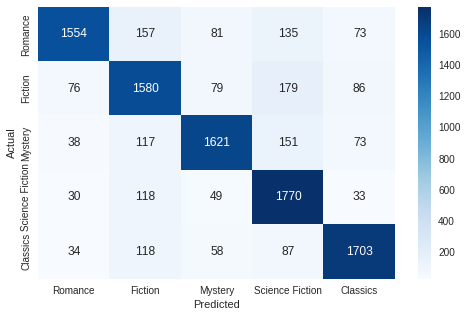

In [48]:
# confusion matrix
cm = confusion_matrix(ytest, y_test_pred)
labels=[x[1] for x in genres_corresp2]
plt.figure(figsize=(8,5))
sns.heatmap(cm, xticklabels=labels, yticklabels=labels, fmt='d', annot=True, cmap=sns.color_palette("Blues", as_cmap=True))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

It seems that "Romance", "Classics" and "Mystery" classes are the easiest to predict than the others (i.e "Fiction" and "Science Fiction") 

In [49]:
print(classification_report(ytest, y_test_pred, target_names=[genre[1] for genre in genres_corresp2]))

                 precision    recall  f1-score   support

        Romance       0.90      0.78      0.83      2000
        Fiction       0.76      0.79      0.77      2000
        Mystery       0.86      0.81      0.83      2000
Science Fiction       0.76      0.89      0.82      2000
       Classics       0.87      0.85      0.86      2000

       accuracy                           0.82     10000
      macro avg       0.83      0.82      0.82     10000
   weighted avg       0.83      0.82      0.82     10000



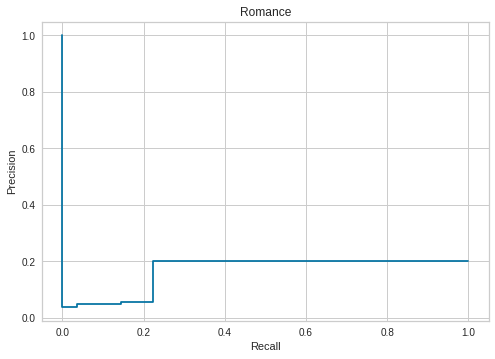

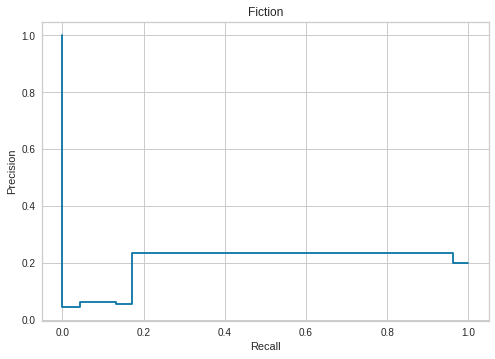

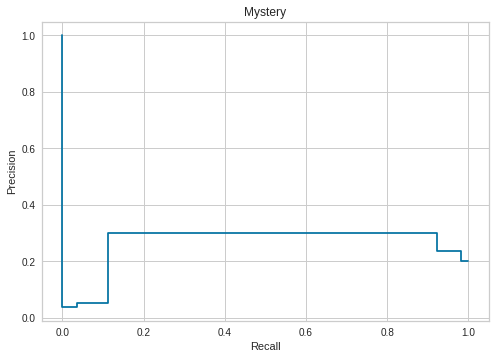

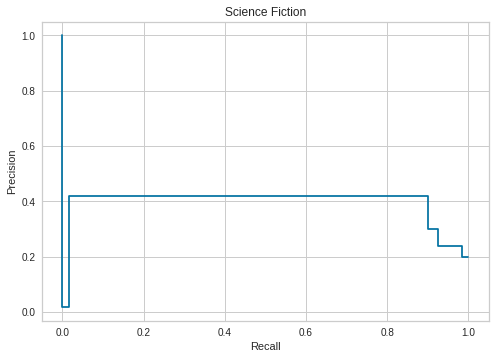

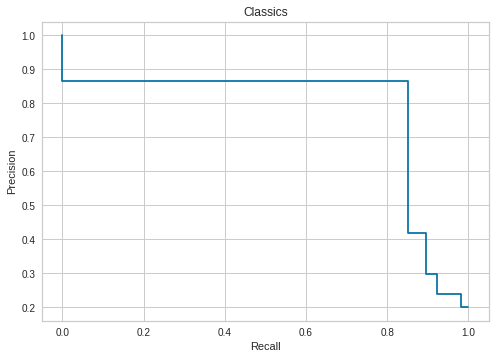

In [50]:
for i,e in enumerate(genres_corresp2):
  prec, recall, _ = precision_recall_curve(ytest, y_test_pred, pos_label=model_naive.classes_[i])
  pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()
  plt.title(e[1])